In [3]:
from caveclient import CAVEclient
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
client = CAVEclient(global_only=True)

In [5]:
# https://annotationframeworkclient.readthedocs.io/en/stable/guide/authentication.html#new-token
client = CAVEclient('minnie65_phase3_v1')
client.info.get_datastack_info()

{'description': 'This is the first version of Minnie that has proofreading enabled. Was first enabled on June 24, 2020. ',
 'analysis_database': None,
 'aligned_volume': {'image_source': 'precomputed://https://bossdb-open-data.s3.amazonaws.com/microns/minnie/minnie65-phase3-em/aligned/v1',
  'description': "This is the second alignment of the IARPA 'minnie65' dataset, completed in the spring of 2020 that used the seamless approach.",
  'name': 'minnie65_phase3',
  'id': 1},
 'local_server': 'https://minnie.microns-daf.com',
 'synapse_table': 'synapses_pni_2',
 'viewer_site': 'http://neuromancer-seung-import.appspot.com/',
 'segmentation_source': 'graphene://https://minnie.microns-daf.com/segmentation/table/minnie3_v1',
 'soma_table': 'nucleus_neuron_svm'}

In [6]:
#client.auth.get_new_token()

In [7]:
# secret file - .cloud? pls don't regenerate
#client.auth.save_token(token="cbf0c535f12057f40e895d1d04dcf79e",overwrite=True)

In [8]:
client.materialize.get_tables()

['functional_coreg',
 'proofreading_functional_coreg_v2',
 'nucleus_detection_v0',
 'allen_v1_column_thalamic',
 'l5_mc_cg',
 'allen_v1_column_pyc_proof',
 'allen_v1_column_types_slanted',
 'allen_minnie_extra_types',
 'synapses_pni_2',
 'allen_v1_column_types_v3',
 'allen_v1_column_types_v2',
 'allen_v1_column_proofreading',
 'nucleus_neuron_svm',
 'allen_soma_coarse_cell_class_model_v1',
 'allen_soma_coarse_cell_class_model_v2',
 'allen_column_l5it_types',
 'allen_column_basket_molecular',
 'allen_column_bodor_surround_inhib',
 'proofreading_status_public_release']

    - allen_v1_column_types_slanted have been manually examined for cell type

    - synapses_pni_2 is a table of the locations of a target cell's synapse according to its input cell

    - allen_soma_coarse_cell_class_model_v1 and v2 is 99% pre-proofread and has the location of all cell bodies in the dataset - difference is that v1 has specific cell types, while v2 is just excitatory/inhibitory

    - nucleus_neuron_svm is a table where each row represents a soma

    positions can be copied n pasted into neuroglancer!

In [9]:
#materialization engine - v120 most recent - 1 exact timestamp
df = client.materialize.query_table('allen_v1_column_types_slanted')
df[0:3]

/usr/local/Caskroom/miniconda/base/envs/brain/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,2,t,aibs_coarse_excitatory,6P,91714732578520135,864691135969106021,"[195744, 241616, 22156]"
1,3,t,aibs_coarse_excitatory,6P,91083063282935716,864691135517345674,"[191408, 253760, 23510]"
2,4,t,aibs_coarse_excitatory,6P,89954208371187610,864691136989929621,"[182912, 232112, 22720]"


In [10]:
np.unique(df.classification_system)

array(['aibs_coarse_excitatory', 'aibs_coarse_inhibitory',
       'aibs_coarse_unclear'], dtype=object)

### Cell type key:

    Number refers to layer, P refers to pyramidal (broadly), IT = intertelencephalon

output cells =
- NP = near-projecting (spooky) (spider) (im scared)
- PT = pyramidal tract
- CT = cortico-thalamic, projects to the thalamus (sensory->thalamus->cortex->loops)
- BC = basket-cell (primarily target the cell body of excitatory neurons), strategically positioned to control spiking and strongly interconnected
- BPC = bipolar cell (VIP = molecular term, dendrites goin up n down) (controls SST) (only some target E), 15% of all interneurons, gain control
- MC = Martinotti (SST = molec term) (primary source of inhib.) targetting distill dendrites & apocal dend., powerful boys, project to layer 1 mediate di-synaptic inhibition between neighboring pyramidal cells
- NGC = neurogliaform cell (instead of pre/post-synaptic, they do volume transmission) spewing GABA, no specific target, (meh categorization)

In [11]:
np.unique(df.cell_type)

array(['23P', '4P', '5P_IT', '5P_NP', '5P_PT', '6CT', '6IT', '6P', 'BC',
       'BPC', 'MC', 'NGC', 'Unsure'], dtype=object)

## Working with a Starter Neuron

    We'll be using a basket cell, as they are well-proofread with a large axon.

In [94]:
root_id = [864691135428608048]
boy = df.query("pt_root_id in @root_id")
boy

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
1317,1341,t,aibs_coarse_inhibitory,BC,89589376669051726,864691135428608048,"[180752, 135200, 22612]"


    Now to look for all cells where the pre-synaptic partner has the same root_id as our start cell...

In [13]:
syn = client.materialize.query_table('synapses_pni_2',filter_equal_dict={'pre_pt_root_id':root_id[0]})
#client.materialize.query_table?
syn[0:3]

/usr/local/Caskroom/miniconda/base/envs/brain/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position
0,163776283,t,90008221812671631,864691135428608048,90008221812657455,864691135428664368,2016,"[183508, 110188, 22121]","[183440, 110198, 22110]","[183515, 110251, 22112]"
1,157606583,t,89171356159545056,864691135428608048,89171356159540486,864691135474718784,8736,"[177664, 166442, 23452]","[177616, 166432, 23445]","[177674, 166500, 23455]"
2,166961633,t,89939434019208858,864691135428608048,89939434019192286,864691136024075321,1684,"[183310, 122030, 25257]","[183308, 122012, 25242]","[183260, 121996, 25250]"


#### synapses table key:

- pre_pt_root_id = pre-synaptic (input cell) we selected for
- post_pt_root_id = post-synaptic cell that the queried cell connects to
- size = volume of synapse in units of supervoxels (most of the time is proportional to strength/weight)

#### synapse has 3 pts associated: 
- 1 just inside the pre-syn side of synapse (on dendrites)
- 1 is just inside the post-syn
- 1 is center point

In [14]:
post_syn = np.unique(syn.post_pt_root_id)
print("There are {0:g} unique post-synaptic connections.".format(len(post_syn)))

There are 2409 unique post-synaptic connections.


    Now we're going to query two different tables, so that we have access to the position of the somas whose dendrites have the post-synaptic connections we just found. The first & second tables aren't proofread; the third is.

In [124]:
somas = client.materialize.query_table('allen_soma_coarse_cell_class_model_v1',filter_in_dict = {'pt_root_id':post_syn})
nuclei = client.materialize.query_table('nucleus_neuron_svm',filter_in_dict = {'pt_root_id':post_syn})
# not many will be in here bc of proofreading stuff
post_slant = client.materialize.query_table('allen_v1_column_types_slanted',filter_in_dict = {'pt_root_id':post_syn})

/usr/local/Caskroom/miniconda/base/envs/brain/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
print("There are {0:g} somas in the table but only {1:g} post-synaptic cells.".format(len(somas),len(post_syn)))
print(len(nuclei))

There are 2520 somas in the table but only 2409 post-synaptic cells.
5234


In [17]:
# checking for merge errors...
nuclei['num_soma'] = nuclei.groupby('pt_root_id').transform('count')['valid']
somas['num_soma'] = somas.groupby('pt_root_id').transform('count')['valid']
mask_somas = somas['num_soma'] < 2
mask_nuclei = nuclei['num_soma'] < 2

In [18]:
post_somas = somas[mask_somas].reset_index(drop=True)
nonmerged_nuclei = nuclei[mask_nuclei].reset_index(drop=True)
print("Now only {0:g} somas remain after removing the root id's that appeared >2".format(len(post_somas)))
print(len(nonmerged_nuclei))

Now only 1741 somas remain after removing the root id's that appeared >2
1713


In [19]:
# need to query another table that actually has cell types
unique_nuclei = np.unique(nonmerged_nuclei.pt_root_id)
post_nuclei = client.materialize.query_table('allen_soma_coarse_cell_class_model_v1',filter_in_dict = {'pt_root_id':unique_nuclei})
len(post_nuclei)

/usr/local/Caskroom/miniconda/base/envs/brain/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


1667

In [98]:
def class_spitter(df):
    classes = np.unique(df.classification_system)
    cellarray = []
    for i in range(len(classes)):
        new = df.query(f"classification_system in @classes[{i}]")
        cellarray.append(new)
    return cellarray

def type_spitter(df):
    types = np.unique(df.cell_type)
    cellarray = []
    for i in range(len(types)):
        new = df.query(f"cell_type in @types[{i}]")
        cellarray.append(new)
    return cellarray

In [78]:
post_slant_class = class_spitter(post_slant)
post_som_class = class_spitter(post_somas)
post_nuc_class = class_spitter(post_nuclei)

post_slant_type = type_spitter(post_slant)
post_som_type = type_spitter(post_somas)
post_nuc_type = type_spitter(post_nuclei)

    "Distance in the y dimension (depth) is quite different from x and z (radial directions). For example, cell types often live specifically at a particular depth, but are scattered widely across the x and z dimensions."

In [84]:
def Eucdistance(pre,post):
    pre_pt = np.array(pre.pt_position) * 4
    x_pre,y_pre,z_pre = pre_pt[0][0],pre_pt[0][1],pre_pt[0][2]*10

    post_pt = post.pt_position.reset_index(drop=True)
    x_pos,y_pos,z_pos = np.zeros(len(post_pt)),np.zeros(len(post_pt)),np.zeros(len(post_pt))
    for i in range(len(post_pt)):
        x_pos[i] = post_pt[i][0] * 4
        y_pos[i] = post_pt[i][1] * 4
        z_pos[i] = post_pt[i][2] * 40
    
    d = np.zeros(len(post_pt))
    for i in range(len(post_pt)):
        d[i] = np.sqrt((x_pre-x_pos[i])**2 + (y_pre-y_pos[i])**2 + (z_pre-z_pos[i])**2)
    
    return d

def Raddistance(pre,post):
    pre_pt = np.array(pre.pt_position) * 4
    x_pre,z_pre = pre_pt[0][0],pre_pt[0][2]*10

    post_pt = post.pt_position.reset_index(drop=True)
    x_pos,z_pos = np.zeros(len(post_pt)),np.zeros(len(post_pt))
    for i in range(len(post_pt)):
        x_pos[i] = post_pt[i][0] * 4
        z_pos[i] = post_pt[i][2] * 40
    
    d = np.zeros(len(post_pt))
    for i in range(len(post_pt)):
        d[i] = np.sqrt((x_pre-x_pos[i])**2 + (z_pre-z_pos[i])**2)
    
    return d

def distance(pre,post):
    d,r = [],[]
    for i in range(len(post)):
        # divide by 1,000 to convert nm to microns
        d_oneclass = Eucdistance(pre,post[i])/1000.
        d.append(d_oneclass)
        r_oneclass = Raddistance(pre,post[i])/1000.
        r.append(r_oneclass)
    return d,r

In [87]:
slant_d_class,slant_r_class = distance(boy,post_slant_class)
som_d_class,som_r_class = distance(boy,post_som_class)
nuc_d_class,nuc_r_class = distance(boy,post_nuc_class)

slant_d_type,slant_r_type = distance(boy,post_slant_type)
som_d_type,som_r_type = distance(boy,post_som_type)
nuc_d_type,nuc_r_type = distance(boy,post_nuc_type)

In [86]:
total = len(slant_d_class[0])+len(slant_d_class[1])+len(slant_d_class[2])
print("{0:.2%} of proofread post-synaptic partners are excitatory,".format(len(slant_d_class[0])/total))
print("{0:.2%} are inhibitory,".format(len(slant_d_class[1])/total))
print("{0:.2%} are unknown.\n".format(len(slant_d_class[2])/total))

total_som = len(som_d_class[0])+len(som_d_class[1])
print("{0:.2%} of un-proofread post-synaptic partners are excitatory,".format(len(som_d_class[0])/total_som))
print("{0:.2%} are inhibitory. (from soma table)\n".format(len(som_d_class[1])/total_som))

total_nuc = len(nuc_d_class[0])+len(nuc_d_class[1])
print("{0:.2%} of un-proofread post-synaptic partners are excitatory,".format(len(nuc_d_class[0])/total_nuc))
print("{0:.2%} are inhibitory. (from nucleus table)".format(len(nuc_d_class[1])/total_nuc))

88.99% of proofread post-synaptic partners are excitatory,
10.71% are inhibitory,
0.30% are unknown.

87.65% of un-proofread post-synaptic partners are excitatory,
12.35% are inhibitory. (from soma table)

87.52% of un-proofread post-synaptic partners are excitatory,
12.48% are inhibitory. (from nucleus table)


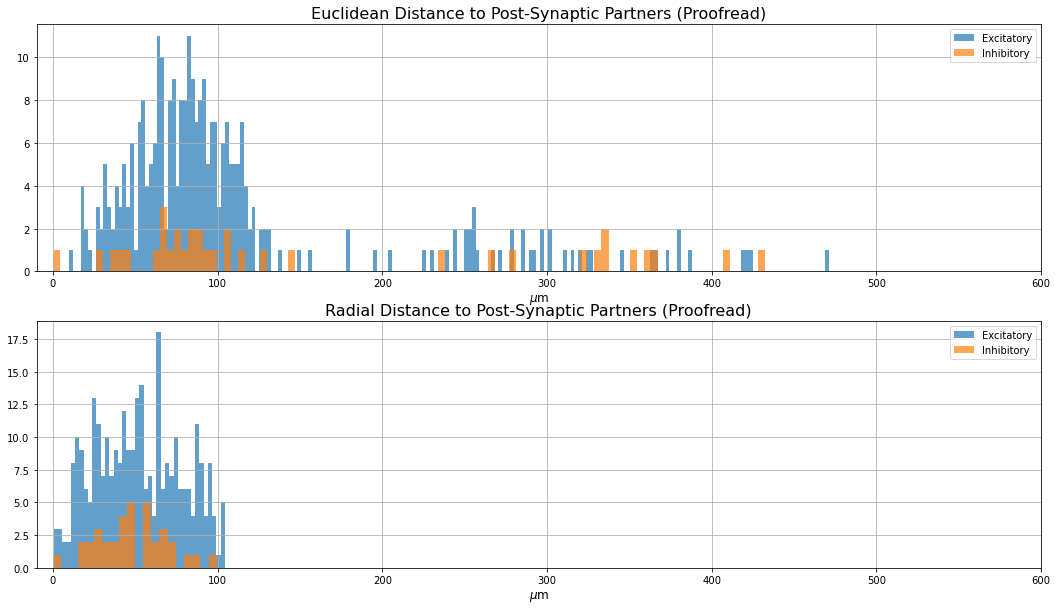

In [144]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(18,10)

ax[0].hist(slant_d_class[0], 200, density=False, label='Excitatory', alpha=.7)
ax[0].hist(slant_d_class[1], 100, density=False, label='Inhibitory', alpha=.7)
ax[0].set_title("Euclidean Distance to Post-Synaptic Partners (Proofread)", fontsize=16)
ax[0].set_xlabel(r'$\mu$m', fontsize=12)
ax[0].legend()
ax[0].grid()

ax[1].hist(slant_r_class[0], 40, density=False, label='Excitatory', alpha=.7)
ax[1].hist(slant_r_class[1], 20, density=False, label='Inhibitory', alpha=.7)
ax[1].set_title("Radial Distance to Post-Synaptic Partners (Proofread)", fontsize=16)
ax[1].set_xlabel(r'$\mu$m', fontsize=12)
ax[1].legend()
ax[1].grid()

#ax[1].set_ylabel("Log Frequency", fontsize=16)
#ax[1].set_yscale('log')

ax[0].set_xlim(-10,600)
ax[1].set_xlim(-10,600)
plt.show()

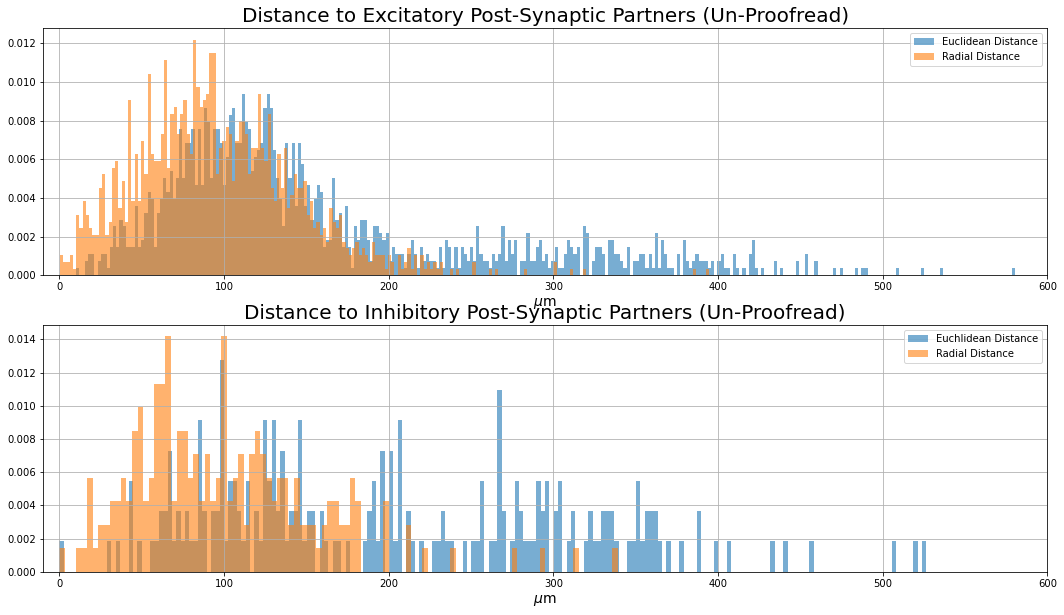

In [137]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(18,10)

ax[0].hist(nuc_d_class[0], 300, label='Euclidean Distance', density=True, alpha=0.6)
ax[0].hist(nuc_r_class[0], 200, label='Radial Distance', density=True, alpha=0.6)
ax[0].set_title("Distance to Excitatory Post-Synaptic Partners (Un-Proofread)", fontsize=20)
ax[0].set_xlabel(r'$\mu$m', fontsize=14)
ax[0].legend()
ax[0].grid()

ax[1].hist(nuc_d_class[1], 200, label='Euchlidean Distance', density=True, alpha=0.6)
ax[1].hist(nuc_r_class[1], 100, label='Radial Distance', density=True, alpha=0.6)
ax[1].set_title("Distance to Inhibitory Post-Synaptic Partners (Un-Proofread)", fontsize=20)
ax[1].set_xlabel(r'$\mu$m', fontsize=14)
ax[1].legend()
ax[1].grid()


#ax.set_ylabel("Log Frequency", fontsize=16)
#plt.yscale('log')

ax[0].set_xlim(-10,600)
ax[1].set_xlim(-10,600)
plt.show()

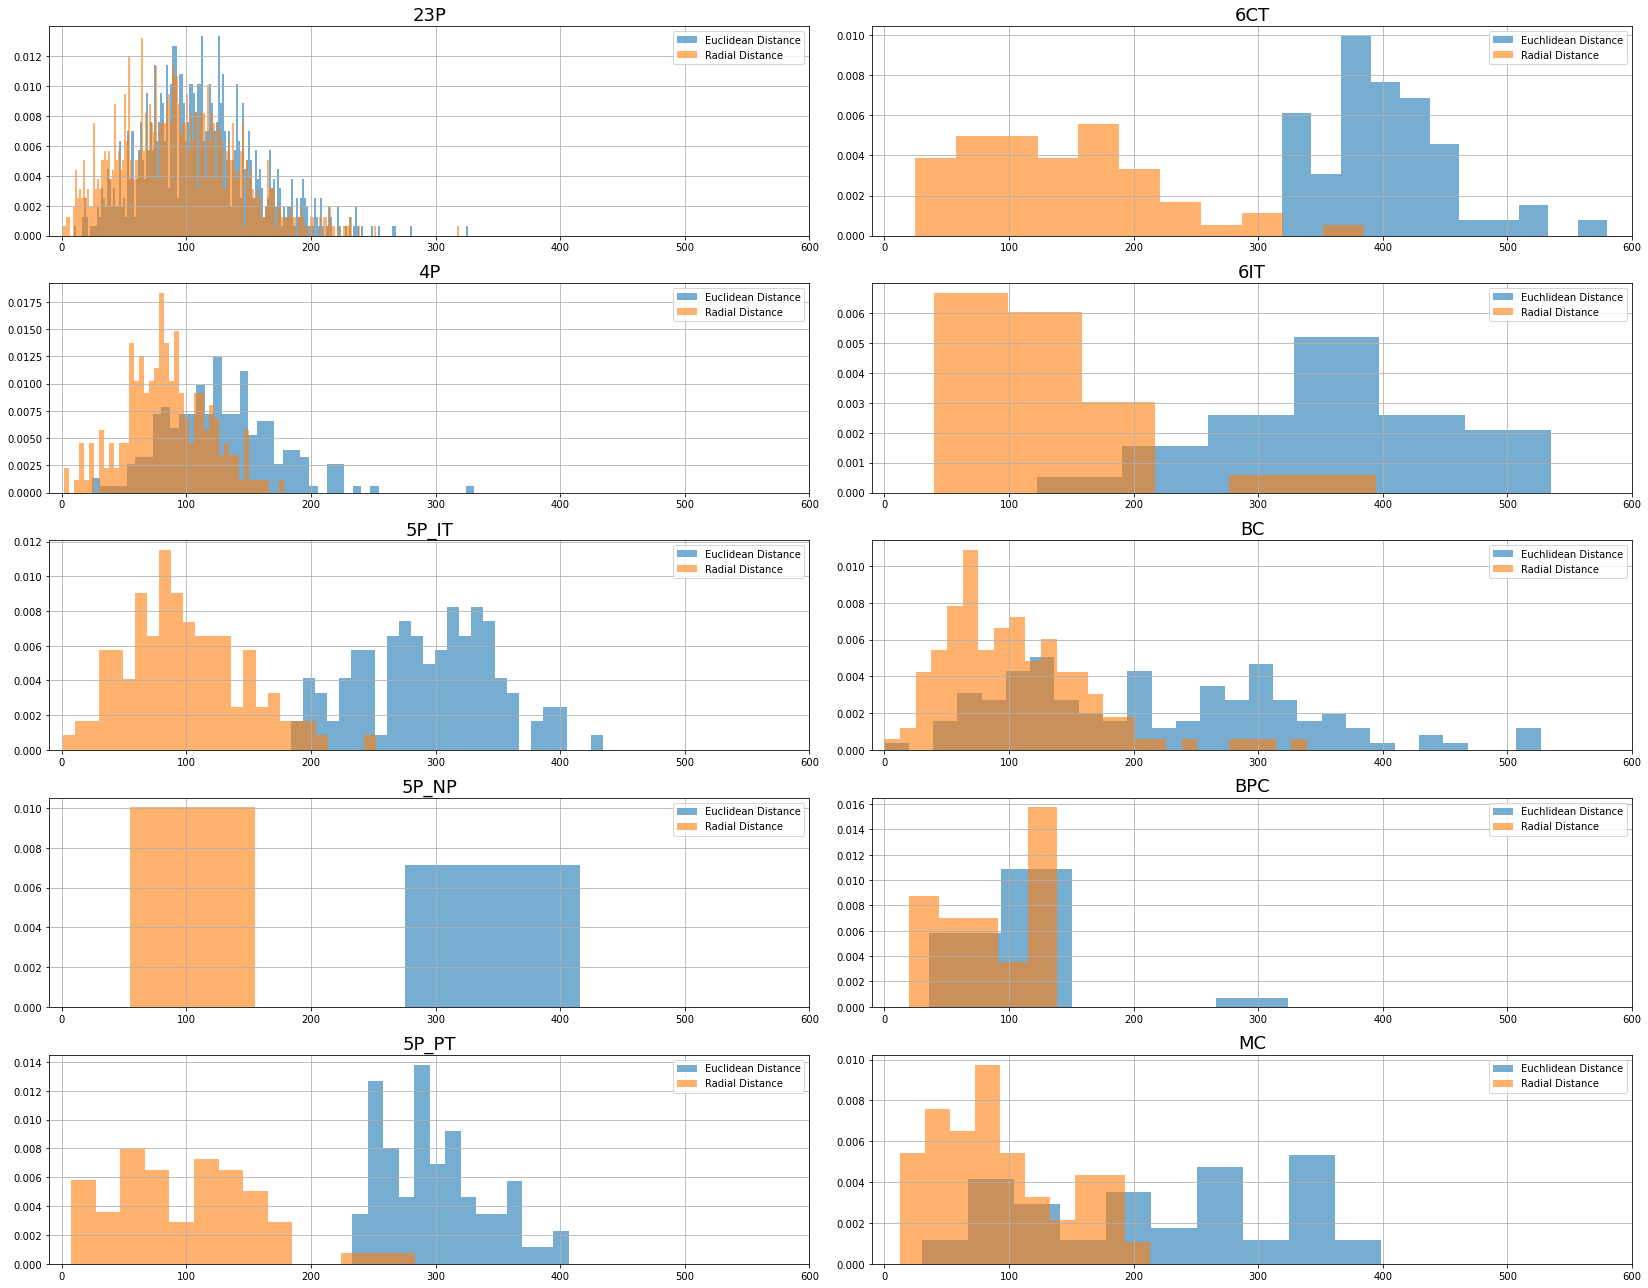

In [145]:
fig, ax = plt.subplots(5,2)
fig.set_size_inches(23,18)

nuc_types = np.unique(post_nuclei.cell_type)
for i in range(10):
    if i < 5:
        ax[i,0].hist(nuc_d_type[i],bins=int(np.ceil(len(nuc_d_type[i])/5)),density=True,label='Euclidean Distance',alpha=0.6);
        ax[i,0].hist(nuc_r_type[i],bins=int(np.ceil(len(nuc_r_type[i])/5)),density=True,label='Radial Distance',alpha=0.6);
        ax[i,0].set_title(nuc_types[i],fontsize=18)
        ax[i,0].grid()
        ax[i,0].legend()
        ax[i,0].set_xlim(-10,600)
    if 5 <= i < 10:
        ax[i-5,1].hist(nuc_d_type[i],bins=int(np.ceil(len(nuc_d_type[i])/5)),density=True,label='Euchlidean Distance',alpha=0.6);
        ax[i-5,1].hist(nuc_r_type[i],bins=int(np.ceil(len(nuc_r_type[i])/5)),density=True,label='Radial Distance',alpha=0.6);
        ax[i-5,1].set_title(nuc_types[i],fontsize=18)
        ax[i-5,1].grid()
        ax[i-5,1].legend()
        ax[i-5,1].set_xlim(-10,600)

fig.tight_layout()
plt.show()